<a href="https://colab.research.google.com/github/BoWarburton/DS-Unit-2-Kaggle-Challenge/blob/master/Bo_Warburton_LS_DS_Sprint_Challenge_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science, Unit 2_
 
# Sprint Challenge: Predict Steph Curry's shots 🏀

For your Sprint Challenge, you'll use a dataset with all Steph Curry's NBA field goal attempts. (Regular season and playoff games, from October 28, 2009, through June 5, 2019.) 

You'll predict whether each shot was made, using information about the shot and the game. This is hard to predict! Try to get above 60% accuracy. The dataset was collected with the [nba_api](https://github.com/swar/nba_api) Python library.

In [0]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

In [0]:
# Read data
import pandas as pd
url = 'https://drive.google.com/uc?export=download&id=1fL7KPyxgGYfQDsuJoBWHIWwCAf-HTFpX'
df = pd.read_csv(url)

# Check data shape
assert df.shape == (13958, 20)

In [172]:
df.dtypes

game_id                      int64
game_event_id                int64
player_name                 object
period                       int64
minutes_remaining            int64
seconds_remaining            int64
action_type                 object
shot_type                   object
shot_zone_basic             object
shot_zone_area              object
shot_zone_range             object
shot_distance                int64
loc_x                        int64
loc_y                        int64
shot_made_flag               int64
game_date                   object
htm                         object
vtm                         object
season_type                 object
scoremargin_before_shot    float64
dtype: object

In [173]:
df.head()

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,game_date,htm,vtm,season_type,scoremargin_before_shot
0,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,2009-10-28,GSW,HOU,Regular Season,2.0
1,20900015,17,Stephen Curry,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,2009-10-28,GSW,HOU,Regular Season,0.0
2,20900015,53,Stephen Curry,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,0,2009-10-28,GSW,HOU,Regular Season,-4.0
3,20900015,141,Stephen Curry,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,0,2009-10-28,GSW,HOU,Regular Season,-4.0
4,20900015,249,Stephen Curry,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,0,2009-10-28,GSW,HOU,Regular Season,0.0


In [174]:
df.isnull().sum()

game_id                    0
game_event_id              0
player_name                0
period                     0
minutes_remaining          0
seconds_remaining          0
action_type                0
shot_type                  0
shot_zone_basic            0
shot_zone_area             0
shot_zone_range            0
shot_distance              0
loc_x                      0
loc_y                      0
shot_made_flag             0
game_date                  0
htm                        0
vtm                        0
season_type                0
scoremargin_before_shot    0
dtype: int64

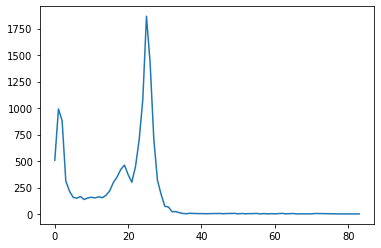

In [175]:
df['shot_distance'].value_counts().sort_index().plot();

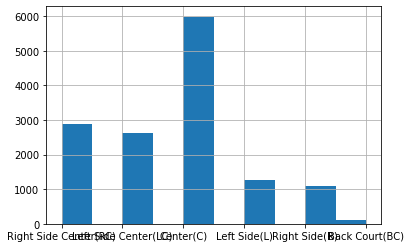

In [176]:
df['shot_zone_area'].hist();

To demonstrate mastery on your Sprint Challenge, do all the required, numbered instructions in this notebook.

To earn a score of "3", also do all the stretch goals.

You are permitted and encouraged to do as much data exploration as you want.

**1. Begin with baselines for classification.** Your target to predict is `shot_made_flag`. What is your baseline accuracy, if you guessed the majority class for every prediction?

**2. Hold out your test set.** Use the 2018-19 season to test. NBA seasons begin in October and end in June. You'll know you've split the data correctly when your test set has 1,709 observations.

**3. Engineer new feature.** Engineer at least **1** new feature, from this list, or your own idea.
- **Homecourt Advantage**: Is the home team (`htm`) the Golden State Warriors (`GSW`) ?
- **Opponent**: Who is the other team playing the Golden State Warriors?
- **Seconds remaining in the period**: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.
- **Seconds remaining in the game**: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
- **Made previous shot**: Was Steph Curry's previous shot successful?

**4. Decide how to validate** your model. Choose one of the following options. Any of these options are good. You are not graded on which you choose.
- **Train/validate/test split: train on the 2009-10 season through 2016-17 season, validate with the 2017-18 season.** You'll know you've split the data correctly when your train set has 11,081 observations, and your validation set has 1,168 observations.
- **Train/validate/test split: random 80/20%** train/validate split.
- **Cross-validation** with independent test set. You may use any scikit-learn cross-validation method.

**5.** Use a scikit-learn **pipeline** to **encode categoricals** and fit a **Decision Tree** or **Random Forest** model.

**6.** Get your model's **validation accuracy.** (Multiple times if you try multiple iterations.) 

**7.** Get your model's **test accuracy.** (One time, at the end.)


**8.** Given a **confusion matrix** for a hypothetical binary classification model, **calculate accuracy, precision, and recall.**

### Stretch Goals
- Engineer 4+ new features total, either from the list above, or your own ideas.
- Make 2+ visualizations to explore relationships between features and target.
- Optimize 3+ hyperparameters by trying 10+ "candidates" (possible combinations of hyperparameters). You can use `RandomizedSearchCV` or do it manually.
- Get and plot your model's feature importances.



## 1. Begin with baselines for classification. 

>Your target to predict is `shot_made_flag`. What would your baseline accuracy be, if you guessed the majority class for every prediction?

In [0]:
target = 'shot_made_flag'

In [178]:
df[target].value_counts(normalize=True)

0    0.527081
1    0.472919
Name: shot_made_flag, dtype: float64

In [179]:
print(f'Percentage of successful shots is {df[target].mean()*100:.0f}%')

Percentage of successful shots is 47%


In [180]:
print(f'Majority class is unsuccessful shot at {(1-df[target].mean())*100:.0f}%')

Majority class is unsuccessful shot at 53%


In [181]:
print('If I guessed the majority class every time, I would be guessing unsuccessful shot all the time.')
print('My accuracy, that is, the sum of true positive and true negatives, all divided by the total population,')
print('would be 53%.')

If I guessed the majority class every time, I would be guessing unsuccessful shot all the time.
My accuracy, that is, the sum of true positive and true negatives, all divided by the total population,
would be 53%.


## 2. Hold out your test set.

>Use the 2018-19 season to test. NBA seasons begin in October and end in June. You'll know you've split the data correctly when your test set has 1,709 observations.

In [182]:
# 'game_date' is a string, so use index reset method
df = df.set_index('game_date')
train = df[:'2018-06'].reset_index()
test  = df['2018-10':].reset_index()
df = df.reset_index()
print('Test set observations:', test.shape[0])
print('Train set observations:', train.shape[0])
print('Test plus train (should equal 13,958 shots taken):', (test.shape[0]+train.shape[0]))

Test set observations: 1709
Train set observations: 12180
Test plus train (should equal 13,958 shots taken): 13889


## 3. Engineer new feature.

>Engineer at least **1** new feature, from this list, or your own idea.
>
>- **Homecourt Advantage**: Is the home team (`htm`) the Golden State Warriors (`GSW`) ?
>- **Opponent**: Who is the other team playing the Golden State Warriors?
>- **Seconds remaining in the period**: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.
>- **Seconds remaining in the game**: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
>- **Made previous shot**: Was Steph Curry's previous shot successful?

    

In [0]:
# Homecourt advantage - integer 1 if htm is GSW, else 0
def get_homecourt_flag (cell_contents):
  if cell_contents == 'GSW':
    return 1
  else:
    return 0

def wrangle(X):
    # Prevent SettingWithCopyWarning
    X = X.copy()

    # Drop useless columns
    useless = ['player_name', 'game_id', 'game_event_id']
    X = X.drop(columns=useless)

    # Engineer features
    X['homecourt_advantage'] = X['htm'].apply(get_homecourt_flag)

    # Date column work
    X['game_date'] = pd.to_datetime(X['game_date'], infer_datetime_format=True)
    
    # return the wrangled dataframe
    return X

## **4. Decide how to validate** your model. 

>Choose one of the following options. Any of these options are good. You are not graded on which you choose.
>
>- **Train/validate/test split: train on the 2009-10 season through 2016-17 season, validate with the 2017-18 season.** You'll know you've split the data correctly when your train set has 11,081 observations, and your validation set has 1,168 observations.
>- **Train/validate/test split: random 80/20%** train/validate split.
>- **Cross-validation** with independent test set. You may use any scikit-learn cross-validation method.

In [184]:
# Train/validate/test split: random 80/20% train/validate split
from sklearn.model_selection import train_test_split
train, val = train_test_split(train,
                              train_size=0.80,
                              test_size=0.20,
                              random_state=37)
print('Training set observations', train.shape[0])
print('Validation set observations', val.shape[0])
print('Total observations', train.shape[0]+val.shape[0])

Training set observations 9744
Validation set observations 2436
Total observations 12180


## 5. Use a scikit-learn pipeline to encode categoricals and fit a Decision Tree or Random Forest model.

In [0]:
train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [186]:
# Get a dataframe with all train columns (predictors) except target
train_features = train.drop(columns=[target])
train_features

,game_date,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,htm,vtm,season_type,scoremargin_before_shot,homecourt_advantage
7988,2016-01-02,2,3,7,Turnaround Jump Shot,3PT Field Goal,Above the Break 3,Left Side Center(LC),24+ ft.,25,-204,154,GSW,DEN,Regular Season,15.0,1
1122,2010-04-14,1,5,55,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-79,140,POR,GSW,Regular Season,2.0,0
3925,2013-04-26,1,5,31,Jump Bank Shot,2PT Field Goal,Mid-Range,Right Side Center(RC),16-24 ft.,17,105,142,GSW,DEN,Playoffs,-2.0,1
5762,2014-11-15,2,4,24,Driving Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,1,-10,4,GSW,CHA,Regular Season,12.0,1
4014,2013-05-06,4,5,34,Driving Finger Roll Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,2,-23,4,SAS,GSW,Playoffs,12.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4118,2013-10-30,2,6,37,Pullup Jump shot,3PT Field Goal,Above the Break 3,Left Side Center(LC),24+ ft.,25,-86,244,GSW,LAL,Regular Season,16.0,1
988,2010-04-02,1,0,39,Driving Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,1,-11,14,GSW,NYK,Regular Season,2.0,1
9036,2016-05-09,4,0,3,Jump Bank Shot,2PT Field Goal,Mid-Range,Right Side(R),8-16 ft.,10,104,26,POR,GSW,Playoffs,-0.0,0
4459,2013-12-11,2,10,54,Pullup Jump shot,2PT Field Goal,Mid-Range,Center(C),16-24 ft.,20,-40,206,GSW,DAL,Regular Season,-9.0,1


In [187]:
# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()
numeric_features

['period',
 'minutes_remaining',
 'seconds_remaining',
 'shot_distance',
 'loc_x',
 'loc_y',
 'scoremargin_before_shot',
 'homecourt_advantage']

In [188]:
# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()
cardinality

game_date          710
action_type         52
shot_type            2
shot_zone_basic      7
shot_zone_area       6
shot_zone_range      5
htm                 32
vtm                 32
season_type          2
dtype: int64

In [189]:
# Get a list of all categorical features with cardinality <= 50
categorical_features_to_encode = cardinality[cardinality <= 50].index.tolist()
categorical_features_to_encode

['shot_type',
 'shot_zone_basic',
 'shot_zone_area',
 'shot_zone_range',
 'htm',
 'vtm',
 'season_type']

In [190]:
# Combine the lists 
features = numeric_features + categorical_features_to_encode
print(features)

['period', 'minutes_remaining', 'seconds_remaining', 'shot_distance', 'loc_x', 'loc_y', 'scoremargin_before_shot', 'homecourt_advantage', 'shot_type', 'shot_zone_basic', 'shot_zone_area', 'shot_zone_range', 'htm', 'vtm', 'season_type']


In [0]:
# Make the train, val dataframes
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

In [0]:
from sklearn.pipeline import make_pipeline
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

In [0]:
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='mean'),
    RandomForestClassifier(n_estimators=999, n_jobs=-1, random_state=37)
    )

In [194]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['shot_type', 'shot_zone_basic',
                                     'shot_zone_area', 'shot_zone_range', 'htm',
                                     'vtm', 'season_type'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', return_df=True,
                               use_cat_names=True, verbose=0)),
                ('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               mis...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,

## 6.Get your model's validation accuracy

> (Multiple times if you try multiple iterations.)

In [195]:
print(f'Validation accuracy: {pipeline.score(X_val, y_val)*100:.2f}%')

Validation accuracy: 55.34%


## 7. Get your model's test accuracy

> (One time, at the end.)

In [196]:
print(f'Test accuracy: {pipeline.score(X_test, y_test)*100:.2f}%')

Test accuracy: 56.29%


## 8. Given a confusion matrix, calculate accuracy, precision, and recall.

Imagine this is the confusion matrix for a binary classification model. Use the confusion matrix to calculate the model's accuracy, precision, and recall.

<table>
  <tr>
    <td colspan="2" rowspan="2"></td>
    <td colspan="2">Predicted</td>
  </tr>
  <tr>
    <td>Negative</td>
    <td>Positive</td>
  </tr>
  <tr>
    <td rowspan="2">Actual</td>
    <td>Negative</td>
    <td style="border: solid">85</td>
    <td style="border: solid">58</td>
  </tr>
  <tr>
    <td>Positive</td>
    <td style="border: solid">8</td>
    <td style="border: solid"> 36</td>
  </tr>
</table>

In [0]:
true_neg = 85
false_neg = 8
true_pos = 36
false_pos = 58
total_pop = true_neg + false_neg + true_pos + false_pos

### Calculate accuracy 

In [198]:
print(f'Accuracy is {(true_pos + true_neg)/total_pop*100:.2f}%')

Accuracy is 64.71%


### Calculate precision

In [199]:
print(f'Precision is {true_pos/(true_pos+false_pos)*100:.2f}%')

Precision is 38.30%


### Calculate recall

In [200]:
print(f'Recall is {true_pos/(true_pos+false_neg)*100:.2f}%')

Recall is 81.82%
